In [140]:
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Model
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from PIL import Image
import shutil
import tensorflow_io as tfio
from tensorflow_examples.models.pix2pix import pix2pix


In [141]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [142]:
# Link: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

# Dataset is comprised of normal brain MRI images and tumor MRI images with glioma
DATASET_PATH = Path("archive/Dataset/tumor/lgg-mri-segmentation/kaggle_3m")

In [143]:
# Get list of all images from dataset folder
images = list(DATASET_PATH.glob("*/*"))
print(len(images))

7858


(256, 256, 3)
0 246


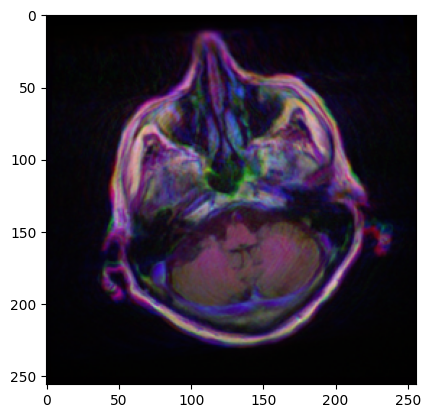

In [144]:
# Show random image (brain MRI or mask)
rand_index = np.random.choice(len(images))
img = np.array(Image.open(images[rand_index]))

print(img.shape)
print(img.min(), img.max())
plt.imshow(img, cmap="gray")

### Define Preprocessing and Visualization Helper Functions

In [145]:
# Normalizes pixel values of an image between [0, 1]
def normalize(image):
    return image / 255.0

def resize(image):
    return tf.image.resize(
        images=image,
        size=(224, 224),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

def preprocess_img(img):
    # Read file from file path
    image = tf.io.read_file(img)

    # Converts to RGBA (4 color channels)
    image = tfio.experimental.image.decode_tiff(image)

    # Convert image to tensor
    image = tf.cast(image, dtype="float32")

    # Normalize pixels in image
    image = normalize(image)

    image = resize(image)
    
    # Get all rows and columns, but only first 3 channels
    image = image[..., :3]
    
    return image

def show_images(images, size=10):
    titles = ["Image", "True Mask", "Predicted Mask"]

    plt.figure(figsize=(size, size))

    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.title(titles[i])
        plt.imshow(images[i], cmap="gray")
        plt.axis("off")
    
    plt.show()

archive\Dataset\tumor\lgg-mri-segmentation\kaggle_3m\TCGA_DU_A5TW_19980228\TCGA_DU_A5TW_19980228_29_mask.tif


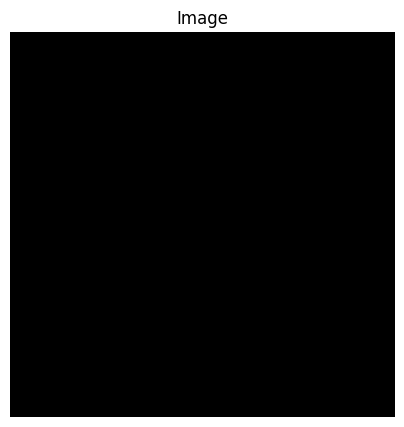

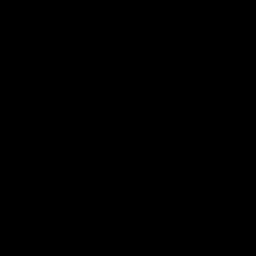

In [146]:
# Preprocess image
rand_index = np.random.choice(len(images))

img = preprocess_img(str(images[rand_index]))

print(str(images[rand_index]))
show_images([img], size=5)
Image.open(images[rand_index])

### Split Dataset into Normal and Tumor Images w/ Masks

In [147]:
def split_images_masks(masks):
    normal_images = []
    tumor_image_mask_pairs = []
    
    # Loop through each mask
    for mask in masks:
        # Convert mask into tensor
        mask_img = preprocess_img(mask)

        # Check if a mask is blank by checking if there is not any white pixels (1)
        if mask_img.numpy().max() == 0:
            # Mask is blank
            normal_img = str(mask)[:-9] + ".tif"

            # Add normal image to normal folder
            normal_images.append(normal_img)
        else:
            # Mask isn't blank
            tumor_img = str(mask)[:-9] + ".tif"

            # Add blank mask and associated image as tuple pair
            tumor_image_mask_pairs.append((tumor_img, mask))
    
    # return list
    return normal_images, tumor_image_mask_pairs

In [148]:
'''
File Directory structure:
dataset
    - Normal images
    - Tumor images
        - tumor
        - mask
'''
NEW_DATASET_PATH = Path("dataset")
NORMAL_PATH = NEW_DATASET_PATH / "normal"
TUMOR_PATH = NEW_DATASET_PATH / "tumor"
TUMOR_IMAGE_PATH = TUMOR_PATH / "images"
TUMOR_MASK_PATH = TUMOR_PATH / "masks"

if not os.path.exists("dataset"):
    # Make folders
    os.mkdir("dataset")
    os.mkdir("dataset/normal")
    os.mkdir("dataset/tumor")
    os.mkdir("dataset/tumor/images")
    os.mkdir("dataset/tumor/masks")
    
    # Get only images of masks
    masks = list(DATASET_PATH.glob("*/*mask*"))
    
    print("Splitting images and masks...")
    
    # Separate normal and tumor images and masks into their own folders
    normal_images, tumor_image_mask_pairs = split_images_masks(masks)

    print("Moving images and masks...")
    # Copy images into new folders
    for image in normal_images:
        shutil.copy(image, NORMAL_PATH)

    for pair in tumor_image_mask_pairs:
        image, mask = pair[0], pair[1]
        shutil.copy(image, TUMOR_IMAGE_PATH)
        shutil.copy(mask, TUMOR_MASK_PATH)

In [149]:
normal_images = list(NORMAL_PATH.glob("*"))
tumor_images = list(TUMOR_IMAGE_PATH.glob("*"))
tumor_masks = list(TUMOR_MASK_PATH.glob("*"))

print(len(list(NORMAL_PATH.glob("*"))))
print(len(list(TUMOR_IMAGE_PATH.glob("*"))))
print(len(list(TUMOR_MASK_PATH.glob("*"))))

2556
1373
1373


### Visualize Preprocessed Images and Masks

dataset\tumor\images\TCGA_FG_6692_20020606_16.tif
dataset\tumor\masks\TCGA_FG_6692_20020606_16_mask.tif


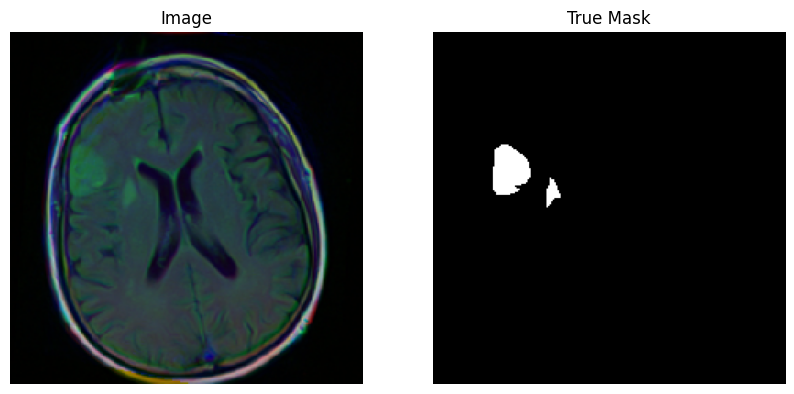

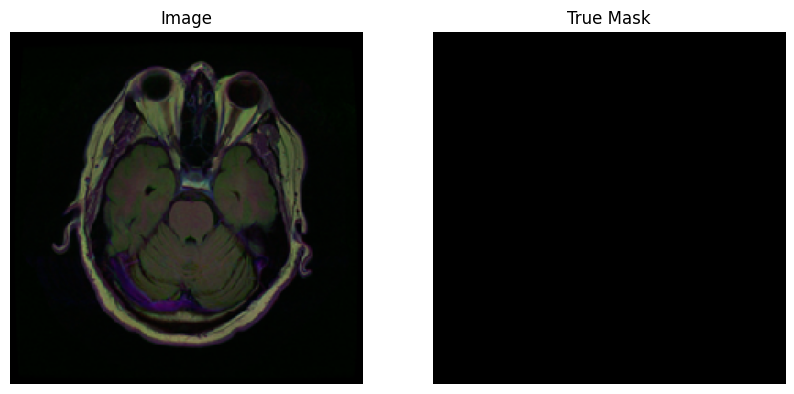

In [150]:
rand_tumor_index = np.random.choice(len(tumor_images))
rand_normal_index = np.random.choice(len(normal_images))

rand_normal_image = normal_images[rand_normal_index]
rand_tumor_image = tumor_images[rand_tumor_index]
rand_mask = tumor_masks[rand_tumor_index]

tumor_image = preprocess_img(str(rand_tumor_image))
mask = preprocess_img(str(rand_mask))
normal_image = preprocess_img(str(rand_normal_image))

print(rand_tumor_image)
print(rand_mask)

show_images([tumor_image, mask])
show_images([normal_image, tf.zeros_like(normal_image)])

### Build Training and Test Dataset

In [151]:
def preprocess_dataset(image, mask):
    return preprocess_img(image), preprocess_img(mask)

In [152]:
BUFFER_SIZE = len(tumor_images) * 2
BATCH_SIZE = 32

In [153]:
# seed is for reproducible and non-shuffled results
images_dataset = tf.data.Dataset.list_files(str(TUMOR_IMAGE_PATH / "*"), seed=42)
masks_dataset = tf.data.Dataset.list_files(str(TUMOR_MASK_PATH / "*"), seed=42)

# Combine both datasets into image, mask pairs
dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

# Apply preprocessing method on image, mask pairs
dataset = dataset.map(preprocess_dataset, num_parallel_calls=tf.data.AUTOTUNE)

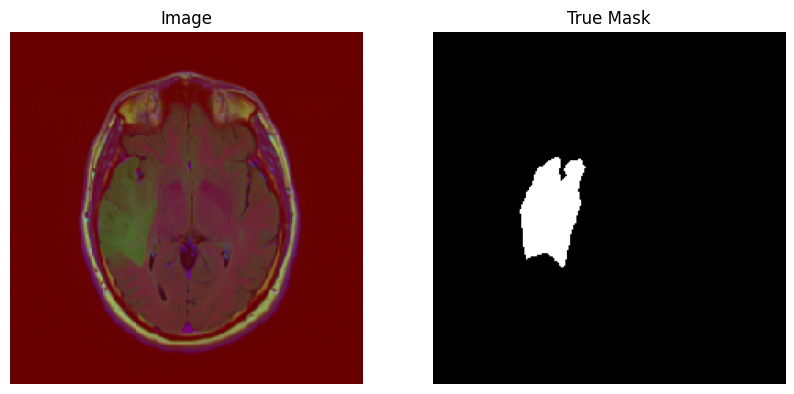

In [154]:
for pair in dataset:
    show_images([pair[0], pair[1]])
    break

In [155]:
# Why is this operation so expensive to run?
train_data, test_data = keras.utils.split_dataset(dataset, left_size=0.8, right_size=0.2, seed=42)

train_data = train_data.shuffle(len(train_data)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.shuffle(len(test_data)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

(224, 224, 3)
(224, 224, 3)


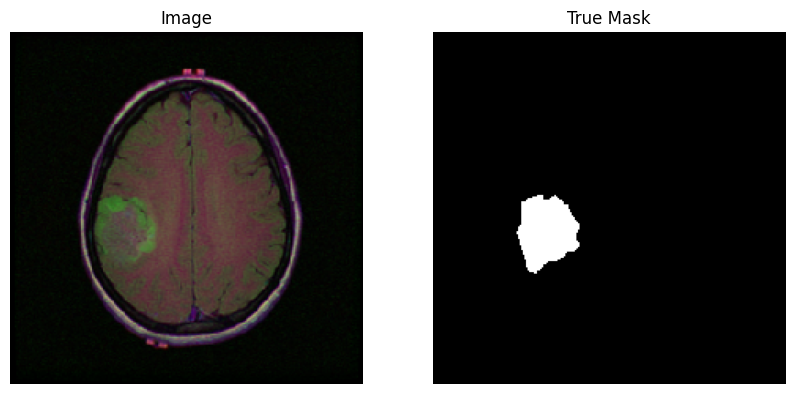

In [156]:
for batch in train_data.take(1):
    images, masks = batch[0], batch[1]
    image, mask = images[0], masks[0]
    
    print(image.shape)
    print(mask.shape)
    show_images([image, mask])

### Define U-NET Model

In [ ]:
# Load in pretrained model
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=[224, 224, 3], 
    include_top=False,
    weights="imagenet"
)

In [158]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                     

In [218]:
# Define downsampling layers by using activation layers in pretrained model
layers = [
    "block2a_expand_activation", # 112 x 112
    "block3a_expand_activation", # 56 x 56
    "block4a_expand_activation", # 28 x 28
    "block6a_expand_activation", # 14 x 14
    "top_activation", # 7 x 7
]

base_model_outputs = [base_model.get_layer(layer).output for layer in layers]

downsample = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
downsample.trainable = False

In [219]:
def upsample_layer(filters, size, apply_dropout=False):
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
upsample = [
    upsample_layer(512, 3, apply_dropout=True), 
    upsample_layer(256, 3),  
    upsample_layer(128, 3),  
    upsample_layer(64, 3),
]

In [221]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = downsample(inputs)

  # Get last element
  x = skips[-1]

  # Reverse
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(upsample, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [222]:
model = unet_model(3)

model.compile(
    optimizer="adam", 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [223]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_14 (Functional)          [(None, 112, 112, 9  4049571     ['input_11[0][0]']               
                                6),                                                               
                                 (None, 56, 56, 144                                               
                                ),                                                                
                                 (None, 28, 28, 240                                        

In [224]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

1/1 [==============================] - 2s 2s/step


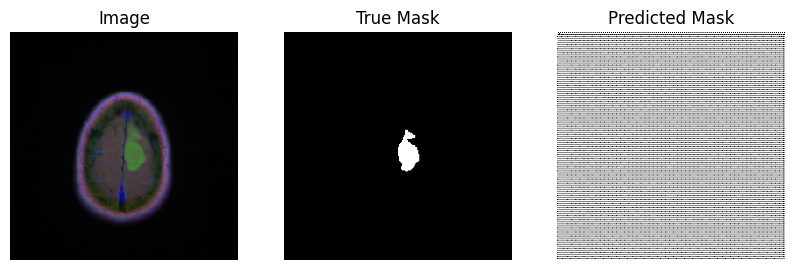

In [225]:
def show_prediction(dataset):
    for batch in dataset.take(1):
        images, masks = batch[0], batch[1]
        image, mask = images[0], masks[0]

        image = tf.expand_dims(image, axis=0)
        mask = tf.expand_dims(mask, axis=0)

        predicted_mask = model.predict(image)
        
        show_images([tf.squeeze(image, axis=0), tf.squeeze(mask, axis=0), create_mask(predicted_mask)])

show_prediction(train_data)

### Train U-NET Model

In [226]:
EPOCHS = 20

In [227]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data=test_data
)

Epoch 1/20
35/35 [==============================] - 13s 224ms/step - loss: 0.2107 - accuracy: 0.0829 - val_loss: 0.1549 - val_accuracy: 0.1219
Epoch 2/20
35/35 [==============================] - 6s 183ms/step - loss: 0.1317 - accuracy: 0.1256 - val_loss: 0.1405 - val_accuracy: 0.3156
Epoch 3/20
35/35 [==============================] - 6s 184ms/step - loss: 0.1190 - accuracy: 0.3298 - val_loss: 0.1644 - val_accuracy: 0.6031
Epoch 4/20
35/35 [==============================] - 6s 183ms/step - loss: 0.1086 - accuracy: 0.4594 - val_loss: 0.1567 - val_accuracy: 0.6310
Epoch 5/20
35/35 [==============================] - 6s 173ms/step - loss: 0.1024 - accuracy: 0.3885 - val_loss: 0.1462 - val_accuracy: 0.4338
Epoch 6/20
35/35 [==============================] - 6s 170ms/step - loss: 0.0985 - accuracy: 0.2988 - val_loss: 0.1261 - val_accuracy: 0.2375
Epoch 7/20
35/35 [==============================] - 6s 182ms/step - loss: 0.0959 - accuracy: 0.2951 - val_loss: 0.1064 - val_accuracy: 0.2151
Epoch

### Visualize Loss

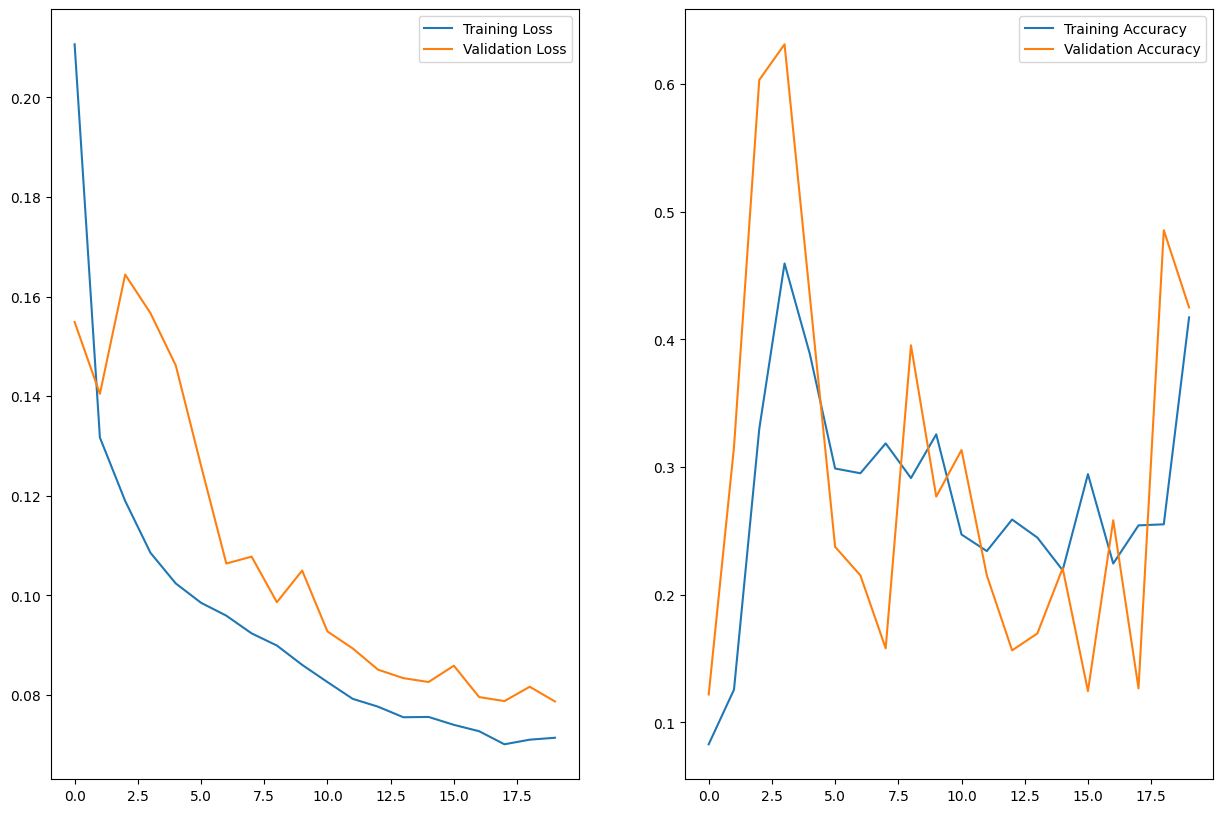

In [228]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()

plt.show()

### Inference

1/1 [==============================] - 0s 34ms/step


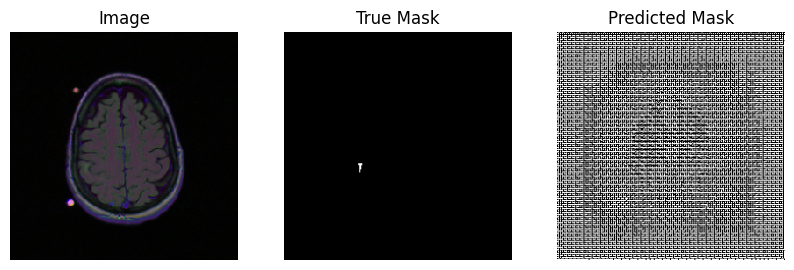

In [229]:
show_prediction(test_data)